In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

In [2]:
# Running funciones_borrador.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IGW_BAR/funciones_borrador.ipynb

## Loading Data

In [3]:
# Loading ssh_hf and making and selecting 1h for testing
ssh_hf = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_01.nc")
ssh_hf_1h = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-01-10T00:30:00')).load()

# Appying the mask to ssh_hf_1h, keep data where mask is equal to 1
mask = xr.open_dataset('/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc',drop_variables={"x","y"}) 
ssh_hf_1h_masked = ssh_hf_1h['ssh_hf'].where(mask.tmaskutil[0,:,:] == 1, np.nan).load()

In [8]:
dx = dy = 1.7 #km

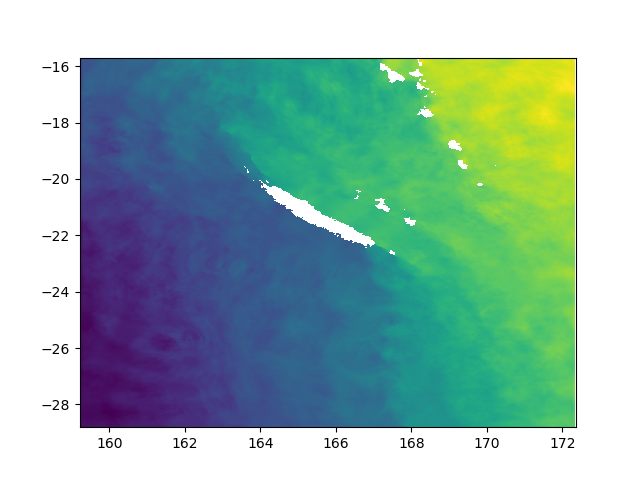

In [11]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked.lon[0,:], ssh_hf_1h_masked.lat[:,0], ssh_hf_1h_masked)
plt.show()

In [20]:
# Filter
date_to_process = '2014-01-10T00:30:00'
lambda_value = 400  # km
ssh_igw, ssh_bar = bar_igw_filter(date_to_process, lambda_bar=lambda_value)

In [21]:
ssh_hf_1h_masked_regular = transform_to_regular_grid(ssh_hf_1h_masked)

## Adding the regular coordinates to the filter output 

In [12]:
# Create an xarray DataArray for ssh_igw using the coordinates from ssh_hf_1h_masked_regular
ssh_igw_da = xr.DataArray(ssh_igw, coords=[ssh_hf_1h_masked_regular.coords['y'], ssh_hf_1h_masked_regular.coords['x']], dims=['y', 'x'])

NameError: name 'ssh_igw' is not defined

In [23]:
# Confirm the shapes
ssh_hf_1h_masked_regular.shape, ssh_igw_da.shape

((867, 829), (867, 829))

In [24]:
# Invert the NaN mask, where 'False' will be where ssh_hf_1h_masked_regular is NaN
not_nan_mask = ~np.isnan(ssh_hf_1h_masked_regular)

# Apply this inverted mask using 'where' to keep NaNs in ssh_igw_da where ssh_hf_1h_masked_regular is NaN
ssh_igw_masked = ssh_igw_da.where(not_nan_mask, np.nan)

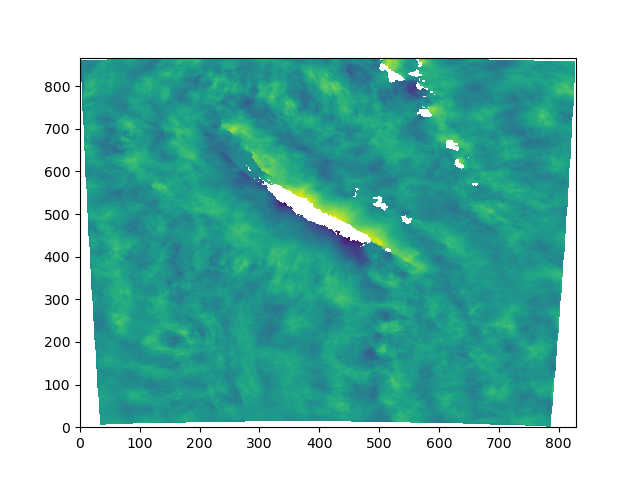

In [25]:
plt.figure()
plt.pcolormesh(ssh_igw_masked)
plt.show()

In [56]:
ssh_igw_masked

<xarray.DataArray (y: 867, x: 829)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 7kB 6.791e+03 6.793e+03 ... 8.262e+03 8.264e+03
  * x        (x) float64 7kB -118.8 -117.1 -115.4 ... 1.287e+03 1.289e+03

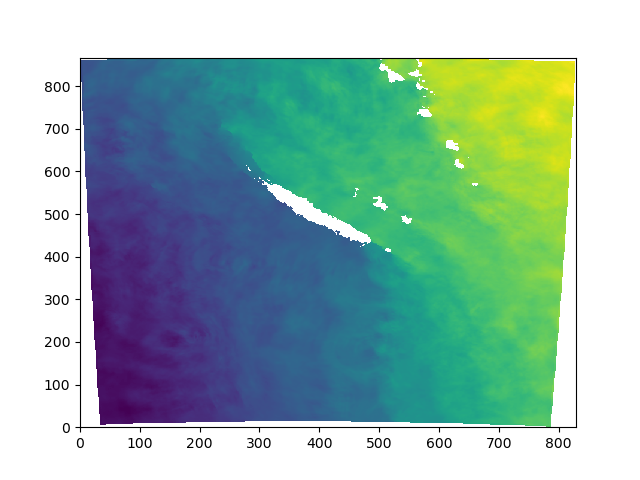

In [26]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked_regular)
plt.show()

## ssh_hf_1h_masked file on UTM

In [26]:
ssh_hf_1h_masked

<xarray.DataArray 'ssh_hf' (y: 853, x: 788)> Size: 5MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan, -0.46211706, -0.46209282, ...,  0.12072774,
         0.12077472,         nan],
       [        nan, -0.46215664, -0.4621357 , ...,  0.12070754,
         0.12075365,         nan],
       ...,
       [        nan, -0.28550266, -0.28544754, ...,  0.33252342,
         0.33249071,         nan],
       [        nan, -0.28555795, -0.28550192, ...,  0.33252699,
         0.33249866,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    lat      (y, x) float32 3MB -28.8 -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon      (y, x) float32 3MB 159.2 159.2 159.3 159.3 ... 172.3 172.3 172.3
Dimensions without coordinates: y, x

In [50]:
# Set up UTM Zone 58S projection
proj = Proj(proj='utm', zone=58, south=True, ellps='WGS84')

# Get latitude and longitude data
lat = ssh_hf_1h_masked.lat
lon = ssh_hf_1h_masked.lon

# Transform lat, lon to UTM coordinates
# Vectorize the transformation for array inputs
x_utm, y_utm = np.vectorize(proj)(lon.values, lat.values)

# Add UTM coordinates to the dataset as new coordinate variables
ssh_hf_1h_masked_utm = ssh_hf_1h_masked.assign_coords({
    'lat_utm': (('y', 'x'), y_utm),
    'lon_utm': (('y', 'x'), x_utm)
})


In [51]:
ssh_hf_1h_masked_utm

<xarray.DataArray 'ssh_hf' (y: 853, x: 788)> Size: 5MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan, -0.46211706, -0.46209282, ...,  0.12072774,
         0.12077472,         nan],
       [        nan, -0.46215664, -0.4621357 , ...,  0.12070754,
         0.12075365,         nan],
       ...,
       [        nan, -0.28550266, -0.28544754, ...,  0.33252342,
         0.33249071,         nan],
       [        nan, -0.28555795, -0.28550192, ...,  0.33252699,
         0.33249866,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    lat      (y, x) float32 3MB -28.8 -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon      (y, x) float32 3MB 159.2 159.2 159.3 159.3 ... 172.3 172.3 172.3
    lat_utm  (y, x) float64 5MB 6.8e+06 6.8e+06 6.8e+06 ... 8.251e+06 8.251e+06
    lon_utm  (y, x) float64 5MB -6.324e+04 -6.161e+04 ... 1.288e+06 1.289e+06
Dimensions without coordinates: y, x

/tmp/ipykernel_184400/4096253756.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_hf_1h_masked_utm.lon_utm, ssh_hf_1h_masked_utm.lat_utm, ssh_hf_1h_masked_utm)


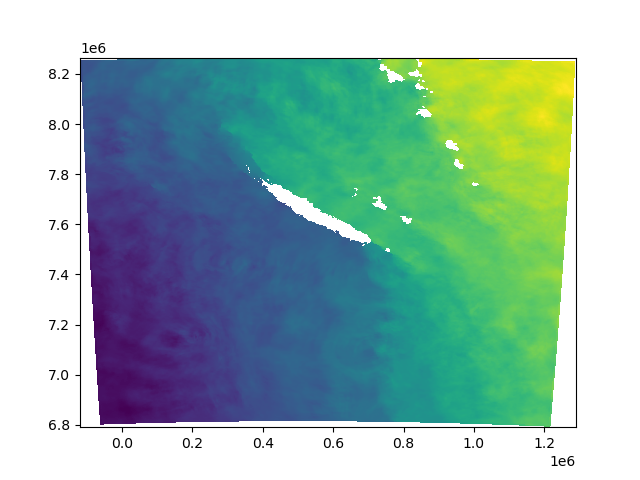

In [54]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked_utm.lon_utm, ssh_hf_1h_masked_utm.lat_utm, ssh_hf_1h_masked_utm)
plt.show()

In [57]:
# Assign UTM coordinates from ssh_hf_1h_masked_utm to ssh_igw_masked
ssh_igw_masked_utm = ssh_igw_masked.assign_coords({
    'lat_utm': ssh_hf_1h_masked_utm.lat_utm,
    'lon_utm': ssh_hf_1h_masked_utm.lon_utm
})

ValueError: cannot reindex or align along dimension 'y' because of conflicting dimension sizes: {867, 853} (note: an index is found along that dimension with size=867)

## interpolation 1d to 2d

In [25]:
ssh_igw_masked

<xarray.DataArray (y: 867, x: 829)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 7kB 6.791e+03 6.793e+03 ... 8.262e+03 8.264e+03
  * x        (x) float64 7kB -118.8 -117.1 -115.4 ... 1.287e+03 1.289e+03

In [65]:
# Set up UTM Zone 58S projection
proj = Proj(proj='utm', zone=58, south=True, ellps='WGS84')

# Create a meshgrid for the 1D coordinates
y_mesh, x_mesh = np.meshgrid(ssh_igw_masked.y, ssh_igw_masked.x, indexing='ij')

# Vectorize and transform to UTM coordinates
x_utm_mesh, y_utm_mesh = np.vectorize(proj)(x_mesh, y_mesh)

# Create new DataArrays for the transformed coordinates
x_utm_da = xr.DataArray(x_utm_mesh, dims=['y', 'x'], coords={'y': ssh_igw_masked.y, 'x': ssh_igw_masked.x})
y_utm_da = xr.DataArray(y_utm_mesh, dims=['y', 'x'], coords={'y': ssh_igw_masked.y, 'x': ssh_igw_masked.x})

# create DA
ssh_igw_masked_2d = ssh_igw_masked.assign_coords({
    'lat_utm': x_utm_da,
    'lon_utm': y_utm_da
})

In [66]:
ssh_igw_masked_2d

<xarray.DataArray (y: 867, x: 829)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 7kB 6.791e+03 6.793e+03 ... 8.262e+03 8.264e+03
  * x        (x) float64 7kB -118.8 -117.1 -115.4 ... 1.287e+03 1.289e+03
    lat_utm  (y, x) float64 6MB inf inf inf inf inf inf ... inf inf inf inf inf
    lon_utm  (y, x) float64 6MB inf inf inf inf inf inf ... inf inf inf inf inf

TypeError: Dimensions of C (867, 829) should be one smaller than X(867) and Y(829) while using shading='flat' see help(pcolormesh)

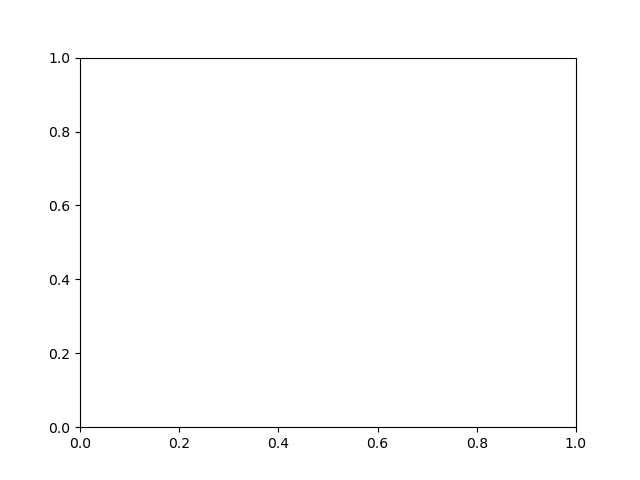

In [69]:
plt.figure()
plt.pcolormesh(ssh_igw_masked.lat_utm, ssh_igw_masked.lon_utm, ssh_igw_masked)
plt.show()

In [67]:
# Example setup of Proj for UTM Zone 58S
proj = Proj(proj='utm', zone=58, south=True, ellps='WGS84')

# Sample coordinates (make sure these are valid for your dataset)
sample_lons = np.array([163, 164])  # Longitudes within the UTM zone
sample_lats = np.array([-10, -11])  # Latitudes below the equator

# Apply transformation
sample_x_utm, sample_y_utm = proj(sample_lons, sample_lats)

print("Transformed UTM Coordinates:")
print("X:", sample_x_utm)
print("Y:", sample_y_utm)

# Check for any infinities
if np.isinf(sample_x_utm).any() or np.isinf(sample_y_utm).any():
    print("Infinite values found, check input ranges and projection settings.")
else:
    print("Transformation successful, coordinates are within expected range.")

Transformed UTM Coordinates:
X: [280766.86116618 390750.98024448]
Y: [8893922.87029434 8783838.63987736]
Transformation successful, coordinates are within expected range.


In [68]:
# Assuming ssh_igw_masked.x and ssh_igw_masked.y are your longitude and latitude arrays
x_mesh, y_mesh = np.meshgrid(ssh_igw_masked.x, ssh_igw_masked.y, indexing='ij')

# Proj setup (as validated)
proj = Proj(proj='utm', zone=58, south=True, ellps='WGS84')

# Transform the full meshgrid
x_utm_mesh, y_utm_mesh = np.vectorize(proj)(x_mesh, y_mesh)

# Handling non-finite values (set to NaN or mask them)
x_utm_mesh[np.isinf(x_utm_mesh)] = np.nan
y_utm_mesh[np.isinf(y_utm_mesh)] = np.nan

# Creating DataArrays
x_utm_da = xr.DataArray(x_utm_mesh, dims=['y', 'x'], coords={'y': ssh_igw_masked.y, 'x': ssh_igw_masked.x})
y_utm_da = xr.DataArray(y_utm_mesh, dims=['y', 'x'], coords={'y': ssh_igw_masked.y, 'x': ssh_igw_masked.x})

# Update your dataset with new coordinates
ssh_igw_masked = ssh_igw_masked.assign_coords({
    'x_utm': x_utm_da,
    'y_utm': y_utm_da
})

# Plotting (now with handled infinities)
plt.figure()
plt.pcolormesh(ssh_igw_masked.x_utm, ssh_igw_masked.y_utm, ssh_igw_masked.variable)  # Replace 'variable' with your data variable name
plt.show()

ValueError: conflicting sizes for dimension 'y': length 829 on the data but length 867 on coordinate 'y'

interpolacion directa? no funciono

In [30]:
# Define target grid from data_masked
target_lon, target_lat = np.meshgrid(ssh_hf_1h_masked.lon, ssh_hf_1h_masked.lat)

# Perform interpolation
interpolated_values = griddata(
    (ssh_igw_masked.lon.values.ravel(), ssh_igw_masked.lat.values.ravel()),  # source grid points
    ssh_igw_masked['variable_name'].values.ravel(),  # source values
    (target_lon, target_lat),  # target grid points
    method='linear'  # interpolation method
)

# Create a new DataArray with the interpolated data
interpolated_data = xr.DataArray(
    interpolated_values,
    coords=[ssh_hf_1h_masked.lat, ssh_hf_1h_masked.lon],
    dims=["lat", "lon"]
)

MemoryError: Unable to allocate 1.64 TiB for an array with shape (672164, 672164) and data type float32

In [9]:
ssh_hf_1h_masked

<xarray.DataArray 'ssh_hf' (y: 853, x: 788)> Size: 5MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan, -0.46211706, -0.46209282, ...,  0.12072774,
         0.12077472,         nan],
       [        nan, -0.46215664, -0.4621357 , ...,  0.12070754,
         0.12075365,         nan],
       ...,
       [        nan, -0.28550266, -0.28544754, ...,  0.33252342,
         0.33249071,         nan],
       [        nan, -0.28555795, -0.28550192, ...,  0.33252699,
         0.33249866,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    lat      (y, x) float32 3MB -28.8 -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    lon      (y, x) float32 3MB 159.2 159.2 159.3 159.3 ... 172.3 172.3 172.3
Dimensions without coordinates: y, x

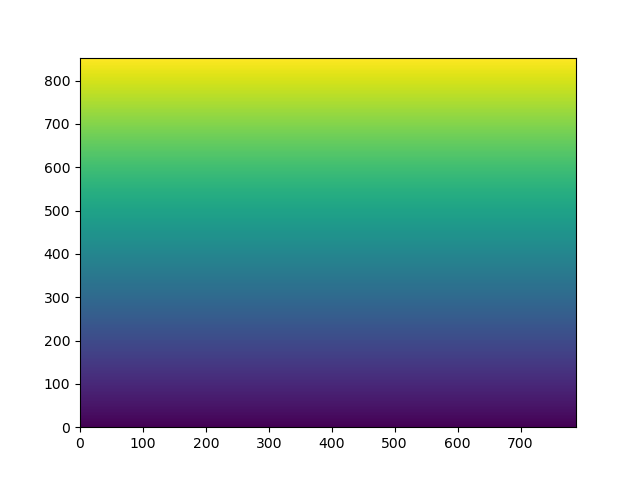

In [10]:
plt.figure()
plt.pcolormesh(ssh_hf_1h_masked.lat)
plt.show()

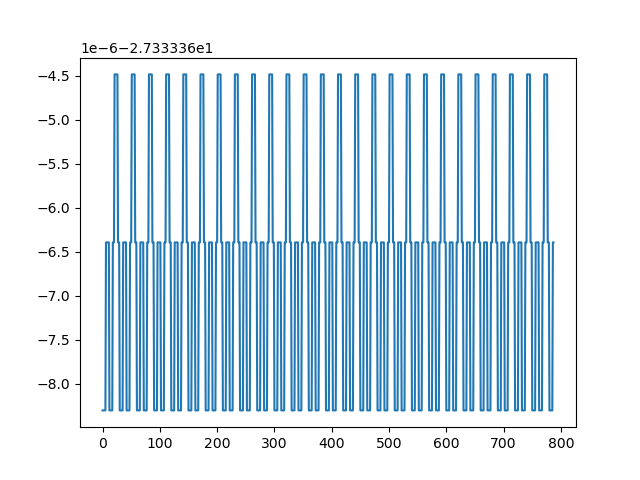

In [12]:
plt.figure()
plt.plot(ssh_hf_1h_masked.lat[100, :].values)
plt.show()

In [16]:
print(ssh_hf_1h_masked.lon[ :,-1].values)

[172.34998 172.34998 172.34998 172.34999 172.34999 172.34999 172.34999
 172.34999 172.34999 172.34999 172.34998 172.34998 172.34998 172.34998
 172.34998 172.34998 172.34998 172.34998 172.34999 172.34999 172.34999
 172.34999 172.34999 172.34999 172.34999 172.34998 172.34998 172.34998
 172.34998 172.34998 172.34998 172.34998 172.34998 172.34999 172.34999
 172.34999 172.34999 172.34999 172.34999 172.34999 172.34998 172.34998
 172.34998 172.34998 172.34998 172.34998 172.34998 172.34998 172.34999
 172.34999 172.34999 172.34999 172.34999 172.34999 172.34999 172.34998
 172.34998 172.34998 172.34998 172.34998 172.34998 172.34998 172.34998
 172.34999 172.34999 172.34999 172.34999 172.34999 172.34999 172.34999
 172.34998 172.34998 172.34998 172.34998 172.34998 172.34998 172.34998
 172.34998 172.34999 172.34999 172.34999 172.34999 172.34999 172.34999
 172.34999 172.34998 172.34998 172.34998 172.34998 172.34998 172.34998
 172.34998 172.34998 172.34999 172.34999 172.34999 172.34999 172.34999
 172.3